In [3]:
# Import Modules
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve
from scipy import ndimage
from PIL import Image
import numpy as np
import os
import sys
import tarfile
import h5py
from numpy import random
import pandas as pd

# Download data
print('Downloading data...')

In [4]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('Download Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

print('Successfully downloaded data!')

Successfully downloaded data!


In [5]:
# Unzip Data
print('Unzipping data...')
np.random.seed(8)

def maybe_extract(filename, force=False):
  # Remove .tar.gz
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

print('Successfully unzipped data!')

Unzipping data...
Extracting data for train. This may take a while. Please wait.
train
Extracting data for test. This may take a while. Please wait.
test
Extracting data for extra. This may take a while. Please wait.
extra
Successfully unzipped data!


In [6]:
# Create dictionary for bounding boxes
print('Creating dictionary of bounding boxes...')
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox
    
    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
    
print("Successfully created dictionary of bounding boxes!")



Creating dictionary of bounding boxes...
Successfully created dictionary of bounding boxes!


In [7]:
import json
# Get Digit Structure
print('Getting digit structure for training data...')
digitFileTrain=DigitStructFile(os.path.join('train','digitStruct.mat'))
train_data=digitFileTrain.getAllDigitStructure_ByDigit()
print('Success!')
print(json.dumps(train_data[0], indent=2))


Getting digit structure for training data...
Success!
{
  "boxes": [
    {
      "width": 81.0, 
      "top": 77.0, 
      "label": 1.0, 
      "left": 246.0, 
      "height": 219.0
    }, 
    {
      "width": 96.0, 
      "top": 81.0, 
      "label": 9.0, 
      "left": 323.0, 
      "height": 219.0
    }
  ], 
  "filename": "1.png"
}


In [8]:
print('Getting digit structure for test data...')
digitFileTest=DigitStructFile(os.path.join('test','digitStruct.mat'))
test_data=digitFileTest.getAllDigitStructure_ByDigit()
print('Success!')
print(json.dumps(test_data[0], indent=2))

Getting digit structure for test data...
Success!
{
  "boxes": [
    {
      "width": 19.0, 
      "top": 7.0, 
      "label": 5.0, 
      "left": 43.0, 
      "height": 30.0
    }
  ], 
  "filename": "1.png"
}


In [9]:
print('Getting digit structure for extra data...')
digitFileExtra=DigitStructFile(os.path.join('extra','digitStruct.mat'))
extra_data=digitFileExtra.getAllDigitStructure_ByDigit()
print('Success!')
print(json.dumps(test_data[0], indent=2))

Getting digit structure for extra data...
Success!
{
  "boxes": [
    {
      "width": 19.0, 
      "top": 7.0, 
      "label": 5.0, 
      "left": 43.0, 
      "height": 30.0
    }
  ], 
  "filename": "1.png"
}


In [10]:

def dict_to_dataframe(image_bounding_boxes, path):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# We store the bounding boxes here
bbox_file = 'bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_dataframe(train_data, 'train/')
    test_df = dict_to_dataframe(test_data, 'test/')
    extra_df = dict_to_dataframe(extra_data, 'extra/')

    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print("Extra", extra_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df, extra_df])
    
    print("Combined", df.shape)
    print('Success!')

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes
    del train_df, test_df, extra_df, train_data, test_data, extra_data
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)

# Display the first 10 rows of dataframe
df.head()

Training (73257, 6)
Test (26032, 6)
Extra (531131, 6)

Combined (630420, 6)
Success!


,filename,height,label,left,top,width
0,train/1.png,219.0,1.0,246.0,77.0,81.0
1,train/1.png,219.0,9.0,323.0,81.0,96.0
2,train/2.png,32.0,2.0,77.0,29.0,23.0
3,train/2.png,32.0,3.0,98.0,25.0,26.0
4,train/3.png,15.0,2.0,17.0,5.0,8.0


In [11]:
# In our cropping procedure we expand the bounding box by 30% in the x and y direction and crop the image. 
# We start by finding the digit sequence bounding box by taking the minimum (x0, y0) and 
# maximum (x1, y1) of each image?
# Rename the columns to more suitable names

df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)

# Calculate x1 and y1
df['x1'] = df['x0'] + df['width']
df['y1'] = df['y0'] + df['height']

# Perform the following aggregations
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             'label':{
                'labels': lambda x: list(x),
                'num_digits': 'count'}}

# Apply the aggration
df = df.groupby('filename').agg(aggregate).reset_index()

# Fix the column names after aggregation
df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

# Display the results
df.head()

/home/ck2886/anaconda2/envs/tensorflow/lib/python2.7/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,filename,y1,y0,x0,x1,labels,num_digits
0,extra/1.png,126.0,23.0,24.0,126.0,"[4.0, 7.0, 8.0]",3
1,extra/10.png,32.0,5.0,5.0,52.0,"[4.0, 4.0, 4.0]",3
2,extra/100.png,30.0,1.0,3.0,46.0,"[5.0, 3.0, 5.0]",3
3,extra/1000.png,40.0,7.0,9.0,36.0,"[2.0, 6.0]",2
4,extra/10000.png,35.0,9.0,8.0,41.0,"[2.0, 10.0, 10.0]",3


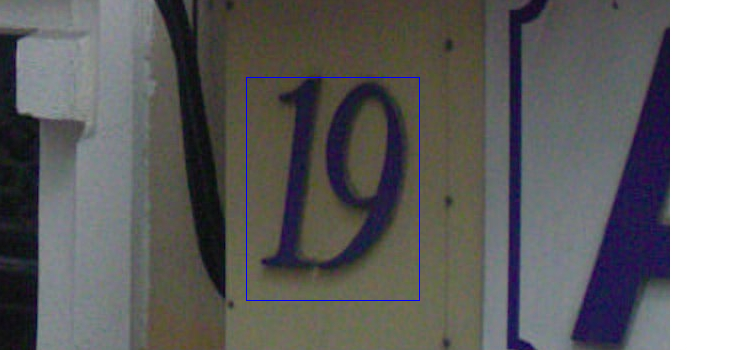

In [12]:
from PIL import Image, ImageDraw

def display_bbox(image_path, bbox):
    """ Helper function to display a single image and bounding box
    """
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image


# Select a image and bounding box
image = 'train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

In [13]:

def get_image_size(filepath):
    """Returns the image size in pixels given as a 2-tuple (width, height)
    """
    image = Image.open(filepath)
    return image.size 

def get_image_sizes(folder):
    """Returns a DataFrame with the file name and size of all images contained in a folder
    """
    image_sizes = []
    
    # Get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    
    # Get image size of every individual image
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes)


# Extract the image sizes
train_sizes = get_image_sizes('train/')
test_sizes = get_image_sizes('test/')
extra_sizes = get_image_sizes('extra/')

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])

# Delete old dataframes
del train_sizes, test_sizes, extra_sizes

# Display 10 image sizes
image_sizes.head(10)

,filename,image_height,image_width
0,train/9122.png,32,74
1,train/26613.png,27,57
2,train/11760.png,174,389
3,train/30724.png,59,137
4,train/26222.png,63,122
5,train/23682.png,49,102
6,train/10658.png,33,64
7,train/29442.png,33,128
8,train/2163.png,92,241
9,train/28506.png,44,86


In [14]:
print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# Inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)

# Delete the image size df
del image_sizes

# Store checkpoint
df.to_csv("image_data.csv", index=False)
#df = pd.read_csv('data/image_data.csv')

df.head()

Bounding boxes (248823, 7)
Image sizes (248823, 3)

Combined (248823, 9)


,filename,y1,y0,x0,x1,labels,num_digits,image_height,image_width
0,extra/1.png,126.0,23.0,24.0,126.0,"[4.0, 7.0, 8.0]",3,141,166
1,extra/10.png,32.0,5.0,5.0,52.0,"[4.0, 4.0, 4.0]",3,41,52
2,extra/100.png,30.0,1.0,3.0,46.0,"[5.0, 3.0, 5.0]",3,32,51
3,extra/1000.png,40.0,7.0,9.0,36.0,"[2.0, 6.0]",2,49,51
4,extra/10000.png,35.0,9.0,8.0,41.0,"[2.0, 10.0, 10.0]",3,44,55


In [15]:
# Count the number of images by number of digits
df.num_digits.value_counts(sort=False)

1     17005
2     98212
3    117561
4     15918
5       126
6         1
Name: num_digits, dtype: int64

In [16]:
# Keep only images with less than 6 digits
df = df[df.num_digits < 6]

In [17]:
df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,248822.00,248822.00
mean,107.93,60.88
std,63.22,32.39
min,22.00,12.00
25%,69.00,40.00
50%,92.00,53.00
75%,127.00,74.00
max,1083.00,516.00


In [18]:
# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_width']

df.head()

,filename,y1,y0,x0,x1,labels,num_digits,image_height,image_width
0,extra/1.png,126.0,23.0,24.0,126.0,"[4.0, 7.0, 8.0]",3,141,166
1,extra/10.png,32.0,5.0,5.0,52.0,"[4.0, 4.0, 4.0]",3,41,52
2,extra/100.png,30.0,1.0,3.0,46.0,"[5.0, 3.0, 5.0]",3,32,51
3,extra/1000.png,40.0,7.0,9.0,36.0,"[2.0, 6.0]",2,49,51
4,extra/10000.png,35.0,9.0,8.0,41.0,"[2.0, 10.0, 10.0]",3,44,55


In [19]:
from scipy.ndimage import imread
from scipy.misc import imresize

def crop_and_resize(image, img_size):
    """ Crop and resize an image
    """
    image_data = imread(image['filename'])
    crop = image_data[int(image['y0']):int(image['y1']), int(image['x0']):int(image['x1']), :]
    return imresize(crop, img_size)


def create_dataset(df, img_size):
    """ Helper function for converting images into a numpy array
    """
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype='uint8')
    y = np.full((df.shape[0], 5), 10, dtype=int)
    
    # Iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        
        # Get the image data
        X[i] = crop_and_resize(image, img_size)
        
        # Get the label list as an array
        labels = np.array((image['labels']))
                
        # Store 0's as 0 (not 10)
        labels[labels==10] = 0
        
        # Embed labels into label array
        y[i,0:labels.shape[0]] = labels
        
    # Return data and labels   
    return X, y


# Change this to select a different image size
image_size = (64, 64)

# Get cropped images and labels (this might take a while...)
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)
X_extra, y_extra = create_dataset(df[df.filename.str.contains('extra')], image_size)

# We no longer need the dataframe
del df

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

Training (33401, 64, 64, 3) (33401, 5)
Test (13068, 64, 64, 3) (13068, 5)
Extra (202353, 64, 64, 3) (202353, 5)


In [18]:
# import matplotlib as plt# Plot a cropped image
# plt.imshow(X_train[0])
# plt.xticks([]); plt.yticks([]);

In [20]:
# Creating a validation set

def random_sample(N, K):
    """Return a boolean mask of size N with K selections
    """
    mask = np.array([True]*K + [False]*(N-K))
    np.random.shuffle(mask)
    return mask

# Pick 4000 training and 2000 extra samples
sample1 = random_sample(X_train.shape[0], 3000)
sample2 = random_sample(X_extra.shape[0], 2000)

# Create valdidation from the sampled data
X_val = np.concatenate([X_train[sample1], X_extra[sample2]])
y_val = np.concatenate([y_train[sample1], y_extra[sample2]])

# Keep the data not contained by sample
X_train = np.concatenate([X_train[~sample1], X_extra[~sample2]])
y_train = np.concatenate([y_train[~sample1], y_extra[~sample2]])

# Moved to validation and training set
del X_extra, y_extra 

print("Training", X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)

Training (230754, 64, 64, 3) (230754, 5)
Validation (5000, 64, 64, 3) (5000, 5)


In [22]:
# Create file

h5f = h5py.File('data/SVHN_multi.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()

In [24]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    for i in images:
        greyscale = np.dot(i, [0.2989, 0.5870, 0.1140])
    return greyscale


# Transform the images to greyscale
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)
X_val = rgb2gray(X_val).astype(np.float32)

print("Training", X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print("Test", X_test.shape, y_test.shape)

Training (64, 64) (230754, 5)
Validation (64, 64) (5000, 5)
Test (64, 64) (13068, 5)


In [25]:

# Create file
h5f = h5py.File('data/SVHN_multi_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()